# Package Download

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install decorator==5.0.9

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple


In [ ]:
import os, sys 
# 挂载google drive
from google.colab import drive 
drive.mount('/content/gdrive') 
 
nb_path = '/content/notebooks'
os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 将安装包安装到指定路径（这里安装到Colab Notebooks/python_package目录下）
!pip install --target=$nb_path -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --target=$nb_path -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --target=$nb_path -q torch-geometric 
!pip install --target=$nb_path decorator==5.0.9 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sparse-0.14.0-py2.py3-none-any.whl (80 kB)


# Package Import

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sparse

ImportError: ignored

In [ ]:
from IPython.display import HTML, display, Javascript
from torch_geometric.datasets import TUDataset
import numpy as np
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


# Data Preparation

In [ ]:
# We will use the Mutagenicity dataset, which is part of the standard datasets in torch geometric.
# downloading may take some time
dataset = TUDataset(root='data/mutagen', name='Mutagenicity', use_node_attr=True, use_edge_attr=False)

Extracting data/mutagen/Mutagenicity/Mutagenicity.zip
Processing...
Done!


In [ ]:
# the below list and dict maps an integer to the corresponiding element string and an element string to a color respectively.
# this will be useful for plotting molecules later on

element_map = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
element_color = {
    'H': [1.0, 1.0, 1.0],
 'Li': [0.8, 0.5019607843137255, 1.0],
 'C': [0.5647058823529412, 0.5647058823529412, 0.5647058823529412],
 'N': [0.18823529411764706, 0.3137254901960784, 0.9725490196078431],
 'O': [1.0, 0.050980392156862744, 0.050980392156862744],
 'F': [0.5647058823529412, 0.8784313725490196, 0.3137254901960784],
 'Na': [0.6705882352941176, 0.3607843137254902, 0.9490196078431372],
 'P': [1.0, 0.5019607843137255, 0.0],
 'S': [1.0, 1.0, 0.18823529411764706],
 'Cl': [0.12156862745098039, 0.9411764705882353, 0.12156862745098039],
 'K': [0.5607843137254902, 0.25098039215686274, 0.8313725490196079],
 'Ca': [0.23921568627450981, 1.0, 0.0],
'Br': [0.6509803921568628, 0.1607843137254902, 0.1607843137254902],
 'I': [0.5803921568627451, 0.0, 0.5803921568627451]}

In [ ]:
print(f'Number of examples: {len(dataset)}')
print('')
print("Let's print a few examples' shape:")
for i in range(4):
    print(dataset[i])

Number of examples: 4337

Let's print a few examples' shape:
Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Data(edge_index=[2, 154], x=[72, 14], edge_attr=[154, 3], y=[1])
Data(edge_index=[2, 26], x=[14, 14], edge_attr=[26, 3], y=[1])
Data(edge_index=[2, 76], x=[36, 14], edge_attr=[76, 3], y=[1])


In [ ]:
def draw_molecule(graph, title=''):
    plt.figure(figsize=(10, 5))
    nodes = {}  # create a node dict (idx:element) to create a nx graph
    for i in range(graph.x.shape[0]):
        element_idx = np.argmax(graph.x[i])
        nodes[i] = element_map[element_idx]
    edges = []  # create an edge list for the nx graph
    for i in range(graph.edge_index.shape[1]):
        s, t = graph.edge_index[:, [i]]
        s, t = int(s), int(t)
        edges.append((s, t))

    g = nx.Graph()  # create a graph
    g.add_nodes_from(nodes)
    g.add_edges_from(edges) 
    
    pos = nx.planar_layout(g)  # the graph has no 'position': generate a node-layout
    pos = nx.spring_layout(g, pos=pos)

    colors = [element_color[i] for _, i in nodes.items()]  # set the color for each node
    nx.draw(g, pos=pos, labels=nodes, node_color=colors, width=1)  # and draw the graph
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")  # color the edges
    
    display(HTML("""<style>#output-body {display: flex;align-items: center;justify-content: center;}</style>"""))  # center the image
    
    plt.title(title)
    plt.show()

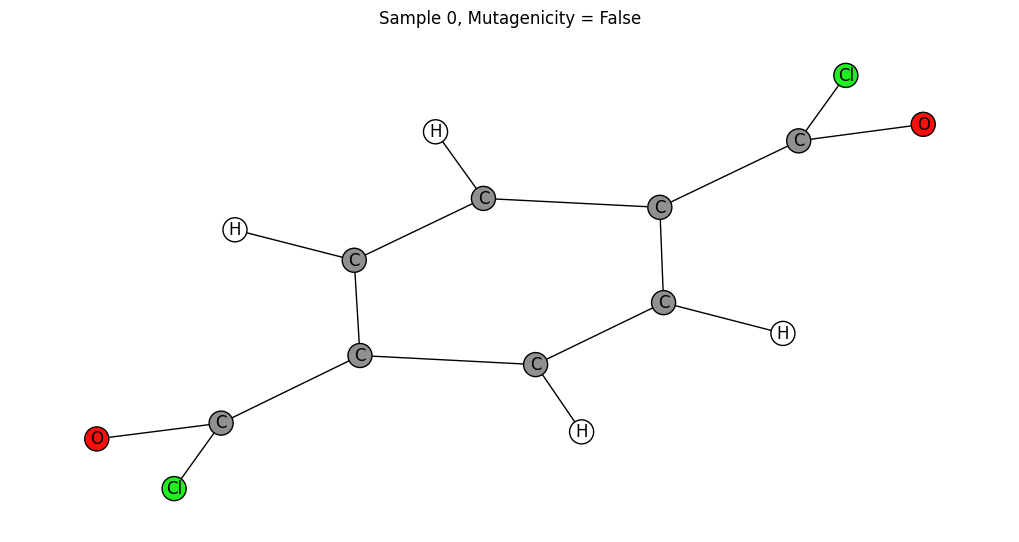

In [ ]:
idx = 0
draw_molecule(dataset[idx], f'Sample {idx}, Mutagenicity = {bool(dataset[idx].y)}')

In [ ]:
'''
We simply shuffle and split the dataset to create a train and validation set.
'''
dataset.shuffle() # first, shuffle our dataset
train_idx = round(len(dataset) * 0.8) # 80:20 for the train:validation split
dataset_train = dataset[:train_idx]
dataset_val = dataset[train_idx:]

In [ ]:
'''
To process the dataset in minibatches, we use a DataLoader object. All we must do
is supply the data and set the batch_size, PyTorch Geometric will take care of the rest.
Note that the batch_size indicates the number of graphs in a batch, not the number of nodes.
'''
from torch_geometric.loader import DataLoader

batch_size = 256
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [ ]:
# To understand how graphs are batched, print one

for data in train_loader:
    print(data[0].edge_index)
    print(type(data[0]))
    print(data[0].edge_index.numpy())
    s = torch.sparse.FloatTensor(data[0].edge_index, torch.ones(1, len(data[0].edge_index[0])), shape=(data[0].x.shape[0], data[0].x.shape[0]))
    print(s)
    
    break

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,
          5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9, 10,
         11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
        [ 1,  2,  3,  9,  0,  2,  4, 10,  0,  1,  0,  5, 11, 12,  1,  6, 13, 14,
          3,  7, 15, 16,  4,  8, 17, 18,  5,  8, 19, 20,  6,  7, 21, 22,  0,  1,
          3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8]])
<class 'torch_geometric.data.data.Data'>
[[ 0  0  0  0  1  1  1  1  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6
   6  6  7  7  7  7  8  8  8  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
 [ 1  2  3  9  0  2  4 10  0  1  0  5 11 12  1  6 13 14  3  7 15 16  4  8
  17 18  5  8 19 20  6  7 21 22  0  1  3  3  4  4  5  5  6  6  7  7  8  8]]


TypeError: ignored

In [ ]:
num_features = int(dataset_train[0].x.shape[1])
num_classes = int(max([d.y for d in dataset_train])+1)
import torch
import torch.nn as nn

In [ ]:
len(dataset_train)

In [ ]:
3470%256

# Model


In [ ]:
class Node_to_emb(nn.Module):  # transforms input nodes to an embedding (similar to word embedding in NLP)
    #### why would an embedding layer be useful?

    def __init__(self, node_feat_dim=14, node_emb_dim=64):
        super().__init__()
        self.emb_dim = node_emb_dim
        self.node_dim = node_feat_dim
        self.emb = nn.Linear(self.node_dim, self.emb_dim)
        

    def forward(self, nodes):
        assert nodes.size(-1) == self.node_dim, 'wrong input dimension of node features!'
        out = self.emb(nodes)
        return out

class MpLayer(torch.nn.Module):  # a neural message passing layer
    def __init__(self, hidden_dim, activation=nn.ReLU()):
        super(MpLayer, self).__init__()
        
        self.edge_network = nn.Sequential(nn.Linear(2*hidden_dim, hidden_dim),
                                          activation,
                                          nn.Linear(hidden_dim, hidden_dim),
                                          activation
                                          )
        
        self.node_network = nn.Sequential(nn.Linear(2*hidden_dim, hidden_dim),
                                          activation,
                                          nn.Linear(hidden_dim, hidden_dim),
                                          )
        
    def forward(self, input_to_layer):
        node_tensor, edge_idx_tensor = input_to_layer
        edge_messages_input = torch.concat([node_tensor[edge_idx_tensor[0,:]], node_tensor[edge_idx_tensor[1,:]]], dim=-1) # shape (num_edges, 2*node_dim + edge_dim)
        edge_messages_output = self.edge_network(edge_messages_input) # shape (num_edges, hidden_dim)
        
        #now aggregate the edge messages for each node the edge points to:
        
        node_agg_messages = torch.zeros(node_tensor.size(0), node_tensor.size(1)).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )
        
        
        #put the aggregated messages through the node update network:
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))

        return node_out, edge_idx_tensor

class MpGNN(torch.nn.Module): # a message passing GNN
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_classes=2):
        super(MpGNN, self).__init__()
        
        #  Hint: the MpGNN must embed the categorical node features, apply message passing layers,
        #        and finally predict the mutagenicity of each graph in the batch.
        
        self.embedding = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp1 = MpLayer(hidden_dim, activation)
        self.mp2 = MpLayer(hidden_dim, activation)
        
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        

    def forward(self, x, edge_index, batch):
        x = self.embedding(x)

        input_model = (x, edge_index)
        output_model = self.mp1(input_model)
        output_model = self.mp2(output_model)
        x, edge_index = output_model
        
        out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
        idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))
    
        out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch
        
        x = self.fc(out)
        return x

class Layer_MpGNN(torch.nn.Module): # a message passing GNN
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_classes=2):
        super(Layer_MpGNN, self).__init__()
        
        #  Hint: the MpGNN must embed the categorical node features, apply message passing layers,
        #        and finally predict the mutagenicity of each graph in the batch.
        
        self.embedding = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp1 = MpLayer(hidden_dim, activation)
        self.mp2 = MpLayer(hidden_dim, activation)
        
        self.fc = nn.Linear(hidden_dim, num_classes)
        

    def forward(self, x, edge_index, batch, training_layer='fc'):
        if training_layer == 'embedding':
            x = self.embedding(x)
            x = (x, edge_index)
            
        elif training_layer == 'mp1': 
            x = self.embedding(x)
            input_model = (x, edge_index)
            x = self.mp1(input_model)
            
        elif training_layer == 'mp2':
            x = self.embedding(x)
            input_model = (x, edge_index)
            output_model = self.mp1(input_model)
            x, edge_index = self.mp2(output_model)

            out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
            idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))
    
            x = out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch
            #print(x, x.shape)
        elif training_layer == 'fc':
            x = self.embedding(x)

            input_model = (x, edge_index)
            output_model = self.mp1(input_model)
            output_model = self.mp2(output_model)
            x, edge_index = output_model
        
            out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
            idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))
    
            x = out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch

        
            x = self.fc(x)
        return x

# Evaluation

In [ ]:
def plot_loss(layer1, epoche, loss_type):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train "+ loss_type)
    plt.xlabel("epoch")
    plt.ylabel(loss_type)
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, layer1)
    #plt.plot(epoche_range, layer2)
    #plt.plot(epoche_range, fc)
    plt.legend([loss_type], loc='best')
    plt.show()

def plot_acc(train, test, epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation Accuarcy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train)
    plt.plot(epoche_range, test)
    #plt.plot(epoche_range, fc)
    plt.legend(['train accuracy', 'test accuracy'], loc='best')
    plt.show()

def eval(model, train_loader = train_loader, isprint=True):
    model.eval()  # set the model to evaluation mode (no dropout)
    
    correct = 0  # keep track of how many we have correct
    total = 0  # and how many we handle in total
    for data in train_loader:  # loop through the supplied dataset in a batch-wise fashion
        data.to(device)  # transfer batch to device
        out = model(data.x, data.edge_index, data.batch)  # propagate the data through the model
        pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
        correct += int((pred == data.y).sum())  # add the number of correct predictions
        total += len(data.y)  # and add the total number of elements
    train_acc = correct / total  # return the accuracy

    correct = 0  # keep track of how many we have correct
    total = 0  # and how many we handle in total
    for data in val_loader:  # loop through the supplied dataset in a batch-wise fashion
        data.to(device)  # transfer batch to device
        out = model(data.x, data.edge_index, data.batch)  # propagate the data through the model
        pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
        correct += int((pred == data.y).sum())  # add the number of correct predictions
        total += len(data.y)  # and add the total number of elements
    val_acc = correct / total  # return the accuracy

    if isprint:
        print('Accuracy of the network on the train: {} %'.format(100 * train_acc))
        print('Accuracy of the network on the test: {} %'.format(100 * val_acc))
    
    return train_acc, val_acc 

# GMI

In [ ]:
import math

torch.autograd.set_detect_anomaly(True)

EPS = 1e-6

class EMALoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()

        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output):
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + EPS) / input.shape[0]
        return grad, None


def ema(mu, alpha, past_ema):
    return alpha * mu + (1.0 - alpha) * past_ema


def ema_loss(x, running_mean, alpha):
    t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach()
    if running_mean == 0:
        running_mean = t_exp
    else:
        running_mean = ema(t_exp, alpha, running_mean.item())
    t_log = EMALoss.apply(x, running_mean)

    # Recalculate ema

    return t_log, running_mean

class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        x = x.view(x.shape[0], -1)
        y = y.view(y.shape[0], -1)
        return torch.cat((x, y), self.dim)


class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class T(nn.Module):
    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + z_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))

    def forward(self, x, z):
        return self.layers(x, z)

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)

        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])

        return -t + second_term

In [ ]:
import scipy.sparse as sp
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    
def negative_sampling(adj_ori, sample_times):
    sample_list = []
    for j in range(sample_times):
        sample_iter = []
        i = 0
        while True:
            randnum = np.random.randint(0,adj_ori.shape[0])
            if randnum!=i:
                sample_iter.append(randnum)
                i = i+1
            if len(sample_iter)==adj_ori.shape[0]:
                break
        sample_list.append(sample_iter)
    return sample_list

def sp_func(arg):
    return torch.log(1+torch.exp(arg))

def mi_loss_jsd(pos, neg):
    e_pos = torch.mean(sp_func(-pos))
    e_neg = torch.mean(torch.mean(sp_func(neg),0))
    return e_pos+e_neg

def reconstruct_loss(pre, gnd):
    nodes_n = gnd.shape[0]
    edges_n = np.sum(gnd)/2
    weight1 = (nodes_n*nodes_n-edges_n)*1.0/edges_n
    weight2 = nodes_n*nodes_n*1.0/(nodes_n*nodes_n-edges_n)
    gnd = torch.FloatTensor(gnd).cuda()
    temp1 = gnd*torch.log(pre+(1e-10))*(-weight1)
    temp2 = (1-gnd)*torch.log(1-pre+(1e-10))
    return torch.mean(temp1-temp2)*weight2

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_ft, out_ft, act, bias=True):
        super(GCN, self).__init__()
        self.fc = nn.Linear(in_ft, out_ft, bias=False)
        self.act = nn.PReLU() if act == 'prelu' else act

        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_ft))
            self.bias.data.fill_(0.0)
        else:
            self.register_parameter('bias', None)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq, adj):
        seq_fts = self.fc(seq)
        out = torch.unsqueeze(torch.spmm(adj, torch.squeeze(seq_fts, 0)), 0)

        if self.bias is not None:
            out += self.bias
        
        return self.act(out), seq_fts

class Discriminator(nn.Module):
    def __init__(self, n_h1, n_h2):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h1, n_h2, 1)
        self.act = nn.Sigmoid()

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, h_c, h_pl, sample_list, s_bias1=None, s_bias2=None):
        sc_1 = torch.squeeze(self.f_k(h_pl, h_c), 2)
        sc_1 = self.act(sc_1)
        sc_2_list = []
        for i in range(len(sample_list)):
            h_mi = torch.unsqueeze(h_pl[0][sample_list[i]],0)
            sc_2_iter = torch.squeeze(self.f_k(h_mi, h_c), 2)
            sc_2_list.append(sc_2_iter)
        sc_2_stack = torch.squeeze(torch.stack(sc_2_list,1),0)
        sc_2 = self.act(sc_2_stack)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        return sc_1, sc_2



# Applies mean-pooling on neighbors
class AvgNeighbor(nn.Module):
    def __init__(self):
        super(AvgNeighbor, self).__init__()

    def forward(self, seq, adj_ori):
        adj_ori = sparse_mx_to_torch_sparse_tensor(adj_ori)
        if torch.cuda.is_available():
            adj_ori = adj_ori.cuda()
        return torch.unsqueeze(torch.spmm(adj_ori, torch.squeeze(seq, 0)), 0)

In [ ]:
class GMI(nn.Module):
    def __init__(self, n_in, n_h, activation):
        super(GMI, self).__init__()
        self.gcn1 = GCN(n_in, n_h, activation)  # if on citeseer and pubmed, the encoder is 1-layer GCN, you need to modify it
        self.gcn2 = GCN(n_h, n_h, activation)
        self.disc1 = Discriminator(n_in, n_h)
        self.disc2 = Discriminator(n_h, n_h)
        self.avg_neighbor = AvgNeighbor()
        self.prelu = nn.PReLU()
        self.sigm = nn.Sigmoid()

    def forward(self, seq1, adj_ori, neg_num, adj, samp_bias1, samp_bias2, alpha=0.8, beta=1.0, gamma=1.0):
        h_1, h_w = self.gcn1(seq1, adj)
        h_2, _ = self.gcn2(h_1, adj)
        h_neighbor = self.prelu(self.avg_neighbor(h_w, adj_ori))
        """FMI (X_i consists of the node i itself and its neighbors)"""
        # I(h_i; x_i)
        res_mi_pos, res_mi_neg = self.disc1(h_2, seq1, negative_sampling(adj_ori, neg_num), samp_bias1, samp_bias2)
        # I(h_i; x_j) node j is a neighbor
        res_local_pos, res_local_neg = self.disc2(h_neighbor, h_2, negative_sampling(adj_ori, neg_num), samp_bias1, samp_bias2)
        """I(w_ij; a_ij)"""
        adj_rebuilt = self.sigm(torch.mm(torch.squeeze(h_2), torch.t(torch.squeeze(h_2))))
        
        #loss = args.alpha*process.mi_loss_jsd(res[0], res[1]) + args.beta*process.mi_loss_jsd(res[2], res[3]) + args.gamma*process.reconstruct_loss(res[4], adj_target)
        #return res_mi_pos, res_mi_neg, res_local_pos, res_local_neg, adj_rebuilt
        return alpha*mi_loss_jsd(res_mi_pos, res_mi_neg) + beta*mi_loss_jsd(res_local_pos, res_local_neg) + gamma*reconstruct_loss(adj_rebuilt, adj_target)

    # detach the return variables
    def embed(self, seq, adj):
        h_1, _ = self.gcn1(seq, adj)
        h_2, _ = self.gcn2(h_1, adj)

        return h_2.detach()

# Train

In [ ]:
def training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval = False):
  result_list = []
  total_step = len(train_loader)
  train_acc_list = []
  test_acc_list = []
  if loss_type != "cross entropy":
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
  for epoch in range(num_epochs):

    #print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    model.train()
    sum_MI = 0
    for data in train_loader:  # loop through the training set in a batch-wise fashion
      data.to(device)  # move the batch to the device (GPU if applicable)
      input_feature = data.x
      input_edge_index = data.edge_index
      y_expanded = torch.zeros(data.y.size(0), 2).to(device)
      y_expanded[:, 0] += data.y == 0
      y_expanded[:, 1] += data.y == 1 
      
      # Forward pass
      outputs  = model(data.x, data.edge_index, data.batch, training_layer = training_layer)  
      if loss_type == '-MI(X;Z)':
        output_feature = outputs[0] 
        output_edge_index = outputs[1]
        
        loss = mine(input_feature, input_edge_index, M_fake).to(device)
      elif loss_type == '-MI(Y;Z)':
        labels = labels.view(labels.shape[0], -1).to(device) 
        loss = mine(labels, outputs).to(device)
      elif loss_type == "cross entropy":
        #labels = labels.view(labels.shape[0], -1).to(device) 
        loss = mine(outputs, labels).to(device)
      
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if loss_type != "cross entropy":
        scheduler.step()
      MI = loss.item()
      sum_MI += MI
   
    avg_MI = sum_MI/total_step
    result_list.append(avg_MI)
    output = 'Epoch [{}/{}], '+ training_layer+' ' + loss_type +' : {:.12f}' 
    print (output.format(epoch+1, num_epochs, avg_MI))
    if iseval:
      if epoch == num_epochs-1:
        isprint = True
      else:
        isprint = False
      train_acc, test_acc = eval(model, isprint=isprint)
      train_acc_list.append(train_acc)
      test_acc_list.append(test_acc)
  if len(train_acc_list) == num_epochs: 
    plot_acc(train_acc_list, test_acc_list, num_epochs)
  
  if iseval:
    return result_list, train_acc_list[-1], test_acc_list[-1]
  else:
    return result_list

# Modular Training

In [ ]:
from torch_geometric.loader import DataLoader
def Modular_training(model, num_epochs, estimator, loss_list, layer_list, train_dataset):
    if len(train_dataset) < 124:
        train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
    else:
        train_loader = DataLoader(dataset=train_dataset, batch_size=124, shuffle=True)
    model.train()
    for param in model.parameters(): 
        param.requires_grad = False
  
    #training embedding
    print("Training embedding")
    for name, param in model.embedding.named_parameters():
        param.requires_grad = True
    mine = estimator[0].to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-7}])
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    emb = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.embedding.named_parameters():
        param.requires_grad = False

    #training mp1
    print("Training mp1")
    for name, param in model.mp1.named_parameters():
        param.requires_grad = True
    mine = estimator[1].to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-7}])
    loss_type = loss_list[1]
    training_layer = layer_list[1]
    mp1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.mp1.named_parameters():
        param.requires_grad = False

    #training mp2
    print("Training mp2")
    for name, param in model.mp2.named_parameters():
        param.requires_grad = True
    mine = Mine(estimator[2]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-6}])
    loss_type = loss_list[2]
    training_layer = layer_list[2]
    mp2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.mp2.named_parameters():
        param.requires_grad = False

    #training fc
    print("Training fc")
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    for name, param in model.fc.named_parameters():
        param.requires_grad = True
    mine = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_type = loss_list[3]
    training_layer = layer_list[3]
    fc, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
    for name, param in model.fc.named_parameters():
        param.requires_grad = False

    return emb, mp1, mp2, fc, train_acc, test_acc
  #return mp1, mp2, fc, train_acc, test_acc

In [ ]:
model = Layer_MpGNN(14,32).to(device).to(device)
T_estimator = [GMI(14, 32, 'prelu'), 
               GMI(14, 32, 'prelu'),
               T(1, 32)]
loss_list = ['-MI(X;Z)', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 10
layer1, layer2, fc1, fc2, _, _ = Modular_training(model, num_epochs, T_estimator, loss_list, layer_list, dataset_train)

Training embedding


ValueError: ignored

In [ ]:
plot_loss(layer1, num_epochs, loss_list[0])
plot_loss(layer2, num_epochs, loss_list[1])
plot_loss(fc1, num_epochs, loss_list[2])
plot_loss(fc2, num_epochs, loss_list[3])

# Save Model

In [ ]:
# save model
model_save_name = 'DIMonMNIST.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}" 
torch.save(model.state_dict(), path)

# Load Model

In [ ]:
# load saved model
model_save_name = 'DIMonMNIST.pt'
path = F"/content/gdrive/MyDrive/ICML/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>